<a href="https://colab.research.google.com/github/kushal19057/nlp-project/blob/main/RobertaBERT_more_input_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.8 MB/s 
     |████████████████████████████████| 182 kB 74.9 MB/s 
     |████████████████████████████████| 7.6 MB 44.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.0 MB/s 
     |████████████████████████████████| 132 kB 64.0 MB/s 
     |████████████████████████████████| 212 kB 66.2 MB/s 
     |████████████████████████████████| 127 kB 65.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import pandas as pd
import numpy as np
import math
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from sklearn.metrics import precision_recall_fscore_support

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 17
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/NLP/H1_Offensive_Language_Identification_train.csv")# df = df.drop(['id'],axis = 1)
df_train.head()

,tweet,label,id
0,@USER She should ask a few native Americans wh...,OFF,0
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,Amazon is investigating Chinese employees who ...,NOT,2
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,3
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,4


In [4]:
print(np.sum(df_train["label"] == "NOT"))
print(np.sum(df_train["label"] == "OFF"))

8840
4400


In [5]:
tweets = list(df_train["tweet"])
tweets[:15]

['@USER She should ask a few native Americans what their take on this is.',
 '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL',
 'Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT',
 '@USER Someone should\'veTaken" this piece of shit to a volcano. 😂"',
 '@USER @USER Obama wanted liberals &amp; illegals to move into red states',
 '@USER Liberals are all Kookoo !!!',
 '@USER @USER Oh noes! Tough shit.',
 '@USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used to divide us on major issues like gun control and terrorism',
 '@USER Buy more icecream!!!',
 '@USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #Qproofs #TrudeauMustGo',
 '@USER @USER @USER It’s not my fault you support gun control',
 '@USER What’s the diff

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
!pip install unidecode

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.7 MB/s 


In [7]:
!pip install demoji
import demoji
import re,string
import unidecode
import random

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = unidecode.unidecode(text) #remove texts such as  àéêöhello
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    # text = [word for word in text.split() if word not in stop_words]
    # text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 50) # remove words longer than 14 characters
    return text

#remove multispace sequences
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not ", text)
    text = re.sub(r"n\'t", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'s ", " is ", text)
    text = re.sub(r"\'d ", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'t", " not ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'m", " am ", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

def preprocessing(tweets):
  clean_tweets = []
  for tweet in tweets:
    
    #cleaning emojis
    if demoji.findall(tweet):
      tweet = demoji.replace_with_desc(tweet,sep=" ")
    #cleaning @USER
    tweet = re.sub(r'@USER',' ',tweet)
    #cleaning URL
    tweet = re.sub(r'URL',' ',tweet)
    #cleaning &amp,&lt,&gt
    tweet = re.sub(r'&[a-zA-Z]+', ' ', tweet)
    #cleaning stopwords,links,punctuations
    tweet = tweet.lower()
#     tweet = decontract(tweet)
#     tweet = clean_hashtags(tweet)
    tweet = strip_all_entities(tweet)
    tweet = remove_mult_spaces(tweet)
    

    clean_tweets.append(tweet)  

  return clean_tweets




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.4 MB/s 


In [8]:
# tweets = list(df["tweet"])
clean_tweets = preprocessing(tweets)
clean_tweets[:15]

['she should ask a few native americans what their take on this is',
 'go home youre drunk maga trump2020 oncoming fist flag united states oncoming fist',
 'amazon is investigating chinese employees who are selling internal data to thirdparty sellers looking for an edge in the competitive marketplace amazon maga kag china tcot',
 'someone shouldvetaken this piece of shit to a volcano face with tears of joy',
 'obama wanted liberals illegals to move into red states',
 'liberals are all kookoo',
 'oh noes tough shit',
 'was literally just talking about this lol all mass shootings like that have been set ups its propaganda used to divide us on major issues like gun control and terrorism',
 'buy more icecream',
 'canada doesnt need another cuck we already have enough looneyleft liberals fking up our great country qproofs trudeaumustgo',
 'its not my fault you support gun control',
 'whats the difference between kavanaugh and one of these men admitted to groping a 15 year old girl years ago

In [9]:
df_train["clean_tweets"] = clean_tweets
clean_tweets_tokens = [sent.split(' ') for sent in clean_tweets]
# print(clean_tweets_tokens)
len_arr = [len(sent) for sent in clean_tweets_tokens]
len_arr = sorted(len_arr)
# print(len_arr)
print(np.mean(len_arr))
print(np.min(len_arr))
print(np.max(len_arr))
print(np.median(len_arr))

20.24108761329305
1
103
16.0


In [10]:
#Encoding the labels
df_train['labels'] = df_train["label"].map({'OFF':0,'NOT':1})
df_train.head()

,tweet,label,id,clean_tweets,labels
0,@USER She should ask a few native Americans wh...,OFF,0,she should ask a few native americans what the...,0
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,go home youre drunk maga trump2020 oncoming fi...,0
2,Amazon is investigating Chinese employees who ...,NOT,2,amazon is investigating chinese employees who ...,1
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,3,someone shouldvetaken this piece of shit to a ...,0
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,4,obama wanted liberals illegals to move into re...,1


In [11]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
import copy
df_train_copy = copy.deepcopy(df_train)
df_train = df_train_copy
display(df_train_copy.head())
df_train = df_train.drop(['tweet','label','id'],axis = 1)
display(df_train)
train_df,val_df = train_test_split(df_train,test_size=0.2)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
# train_dataset = Dataset.from_pandas(train_df)
# val_dataset = Dataset.from_pandas(val_df)


,tweet,label,id,clean_tweets,labels
0,@USER She should ask a few native Americans wh...,OFF,0,she should ask a few native americans what the...,0
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,go home youre drunk maga trump2020 oncoming fi...,0
2,Amazon is investigating Chinese employees who ...,NOT,2,amazon is investigating chinese employees who ...,1
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,3,someone shouldvetaken this piece of shit to a ...,0
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,4,obama wanted liberals illegals to move into re...,1


,clean_tweets,labels
0,she should ask a few native americans what the...,0
1,go home youre drunk maga trump2020 oncoming fi...,0
2,amazon is investigating chinese employees who ...,1
3,someone shouldvetaken this piece of shit to a ...,0
4,obama wanted liberals illegals to move into re...,1
...,...,...
13235,sometimes i get strong vibes from people and t...,0
13236,benidorm check mark button creamfields check m...,1
13237,and why report this garbage we dont give a crap,0
13238,pussy,0


### Dataset formation

In [12]:
class GPReviewDataset(Dataset):

  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweets = str(self.tweets[item])
    labels = self.labels[item]
    
    


    encoding = self.tokenizer.encode_plus(
      tweets,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation = True,
      return_tensors='pt',
    )

    return {
      'tweets': tweets,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(labels, dtype=torch.long)
    }

In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    tweets=df.clean_tweets.to_numpy(),
    labels=df.labels.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [20]:
from transformers import RobertaTokenizer, RobertaModel
BATCH_SIZE = 16
# tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer = tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

MAX_LEN = 103

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [21]:
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 103])
torch.Size([16, 103])
torch.Size([16])


### Model Initialization

In [22]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes,freeze_bert = False
               ,filter_sizes=[1,2,3,4,5],
                num_filters=[32,32,32,32,32]):
    super(SentimentClassifier, self).__init__()
    
    self.bert = RobertaModel.from_pretrained('roberta-base',output_hidden_states = True)
 
    
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(768*4,50),
        nn.GELU(),
        nn.Linear(50,2),
        nn.GELU(),
        nn.Softmax()
    )
    
    if freeze_bert:
        for param in self.bert.parameters():
            param.requires_grad = False
  
  def mean_pooling(self,token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool
  def forward(self, input_ids, attention_mask):
    m_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    m_hs = m_output['hidden_states'] 
    pooled_output_1 = m_hs[6][:,0,:]
    pooled_output_2 = m_hs[5][:,0,:]
    pooled_output_3 = m_hs[4][:,0,:]
    pooled_output_4 = m_hs[3][:,0,:]
    pooled_output = torch.cat(
        (pooled_output_1,pooled_output_2,pooled_output_3,pooled_output_4),dim = -1)
    output = self.classifier(pooled_output)
    return output

In [23]:
model = SentimentClassifier(2)
print(data['input_ids'].shape)
model(data['input_ids'],data['attention_mask'])

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([16, 103])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.4810, 0.5190],
        [0.4892, 0.5108],
        [0.4527, 0.5473],
        [0.4573, 0.5427],
        [0.4855, 0.5145],
        [0.4479, 0.5521],
        [0.4439, 0.5561],
        [0.4633, 0.5367],
        [0.4771, 0.5229],
        [0.4477, 0.5523],
        [0.4629, 0.5371],
        [0.4670, 0.5330],
        [0.4818, 0.5182],
        [0.4586, 0.5414],
        [0.4707, 0.5293],
        [0.4650, 0.5350]], grad_fn=<SoftmaxBackward0>)

In [24]:
model = SentimentClassifier(2)
model = model.to(device)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training

In [25]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=5e-5,    # Default learning rate
                      eps=1e-8)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  true_labels = []
  pred_labels = []
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    
    _, preds = torch.max(outputs, dim=1)
    
   

    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    pred_labels.extend(list(torch.detach(preds).cpu().numpy()))
    true_labels.extend(list(torch.detach(labels).cpu().numpy()))
    
  p,r,f,n = precision_recall_fscore_support(true_labels,pred_labels, average='macro')
  print(f'F1-Score {f}:  Recall {r}:   Precision{p}')
  return correct_predictions.double() / n_examples, np.mean(losses)
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  pred_labels= []
  true_labels = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      pred_labels.extend(list(torch.detach(preds).cpu().numpy()))
      true_labels.extend(list(torch.detach(labels).cpu().numpy()))
    
  p,r,f,n = precision_recall_fscore_support(true_labels,pred_labels, average='macro')
  print(f'F1-Score {f}:  Recall {r}:   Precision{p}')
  
  return correct_predictions.double() / n_examples, np.mean(losses)  

In [27]:
##### %%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Roberta_base_more_input_layers.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
F1-Score 0.6788287836231262:  Recall 0.6678253035172885:   Precision0.7259634160358474
Train loss 0.560530950880843 accuracy 0.5966012084592145


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


F1-Score 0.7498766805554098:  Recall 0.7360626547752376:   Precision0.778129857568884
Val   loss 0.5150413917130735 accuracy 0.7960725075528701

Epoch 2/5
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


F1-Score 0.7428401206605888:  Recall 0.7274223173962258:   Precision0.7837612896843834
Train loss 0.5209072286268736 accuracy 0.6328549848942598


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


F1-Score 0.7086989078260039:  Recall 0.6922867937509406:   Precision0.7718950111793139
Val   loss 0.5346283729535988 accuracy 0.777190332326284

Epoch 3/5
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


F1-Score 0.7533630733821384:  Recall 0.7364808783577655:   Precision0.7988159414456011
Train loss 0.5103914780919285 accuracy 0.6404078549848943


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


F1-Score 0.742609801357402:  Recall 0.7281236338570853:   Precision0.7748141450673096
Val   loss 0.5180139189743134 accuracy 0.7919184290030211

Epoch 4/5
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


F1-Score 0.7715642107530117:  Recall 0.7537157041149837:   Precision0.8160319145625303
Train loss 0.49641614652652394 accuracy 0.6514350453172205


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


F1-Score 0.7368942872194952:  Recall 0.7212511409634716:   Precision0.7760384703234391
Val   loss 0.5211054345211351 accuracy 0.7900302114803626

Epoch 5/5
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


F1-Score 0.7916947461978605:  Recall 0.7740433913534656:   Precision0.8304050254625392
Train loss 0.4834441872611867 accuracy 0.6629154078549849


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


F1-Score 0.7413330943171093:  Recall 0.7279949598895554:   Precision0.7691798834965198
Val   loss 0.5210801969809704 accuracy 0.7892749244712991



### Graph

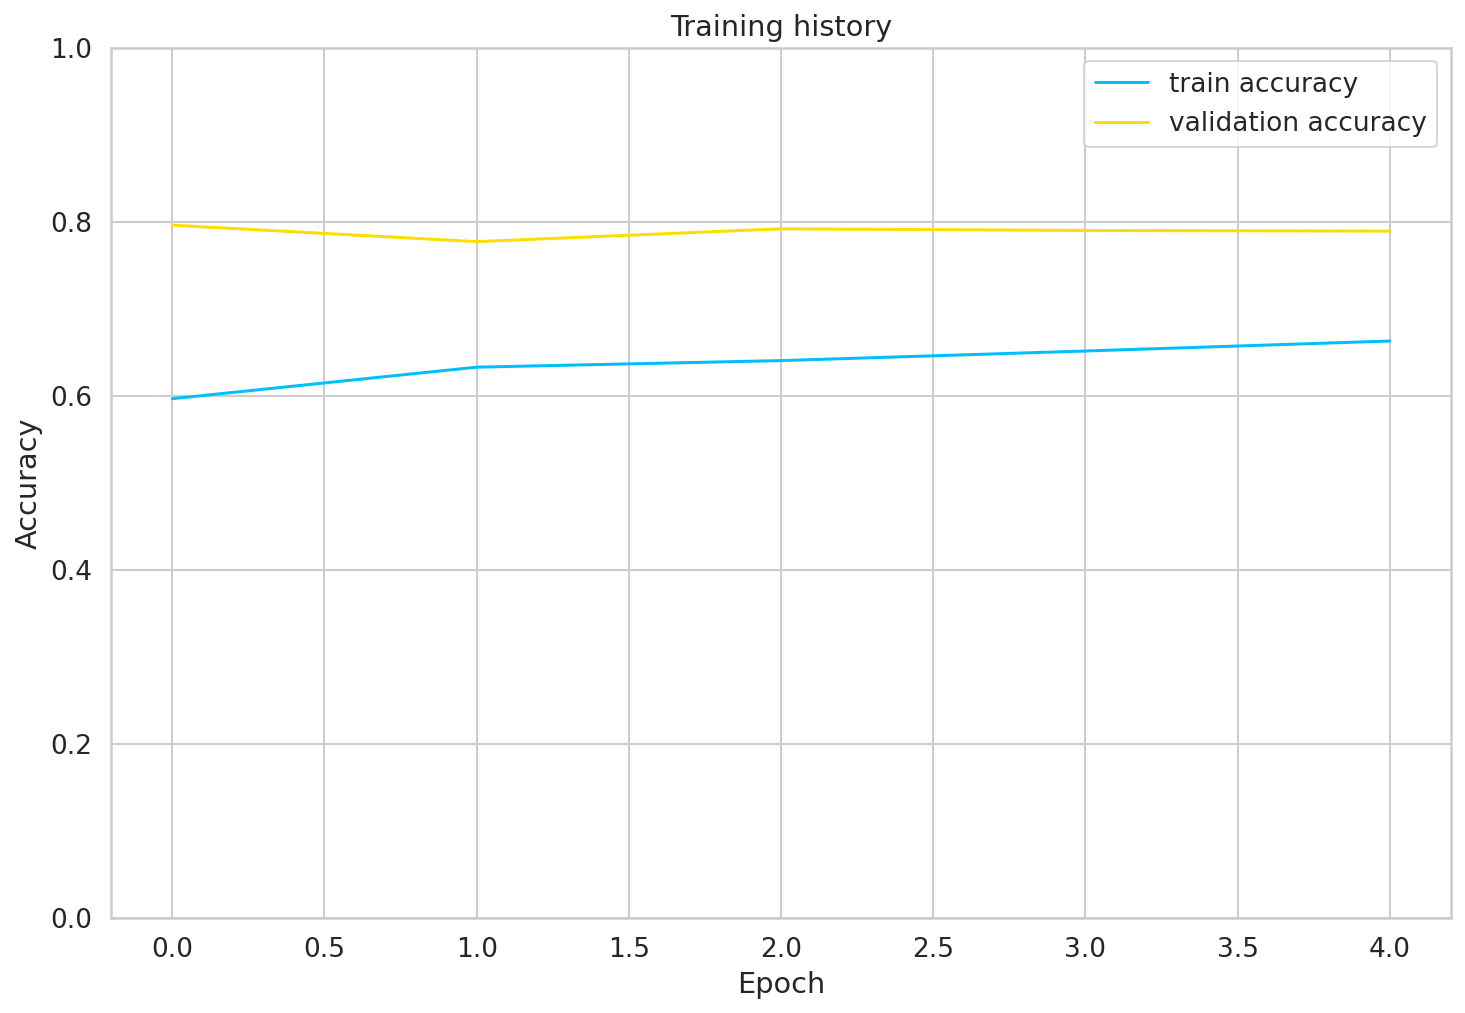

In [28]:
tl= list(map(lambda x:(torch.detach(x).cpu()).tolist(),history['train_acc']))
vl = list(map(lambda x:(torch.detach(x).cpu()).tolist(),history['val_acc']))
plt.plot(tl, label='train accuracy')
plt.plot(vl, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);